# Statistics for regression model

Absolute and relative error for Lab images of glasses and cups model.

In [1]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = '2022-09-20_OnlyCuasi'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 2                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects(), compile=True)

W0921 09:52:54.516402 140036140152640 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0921 09:52:54.517842 140036140152640 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0921 09:52:54.518866 140036140152640 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

In [12]:
import pandas as pd
# Load back the predictions
SPLIT_NAME='test'
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path) as f:
    pred_dict = json.load(f)

df_pred=pd.DataFrame(pred_dict)
df_pred['abs_error']=abs(df_pred.pred_value-df_pred.true_value)

In [13]:
# df_pred['filenames'].apply(lambda x: x.split('_')[-4] if "Voluntarios" in x else x.split('_')[3])

In [14]:
# extract values of angle, plane and background in all images
# df_pred['date'] = df_pred.apply(lambda row: row.filenames.split('_')[-2], axis=1)
# df_pred['time'] = df_pred.apply(lambda row: row.filenames.split('_')[-1].split('.')[0], axis=1)
df_pred['glass'] = df_pred.apply(lambda row: row.filenames.split('_')[-4] if "Voluntarios" in row.filenames else row.filenames.split('_')[3], axis=1)
# df_pred['type_glass'] = df_pred['filenames'].apply(lambda x: x.split('_')[4] if "Voluntarios" in x else x.split('_')[3])
df_pred['vol'] = df_pred['filenames'].apply(lambda x: x.split('_')[3] if "Voluntarios" in x else x.split('_')[4])
# df_pred['meal'] = df_pred.apply(lambda row: row.filenames.split('_')[-3], axis=1)
#df_pred['light'] = df_pred.apply(lambda row: row.filenames.split('_')[-5], axis=1)
df_pred.head(5)

,filenames,pred_value,true_value,abs_error,glass,vol
0,/srv/data/cuasiReales/La Rioja/ICVV/Copa Chard...,116.828697,125,8.171303,Char,125
1,/srv/data/cuasiReales/La Rioja/ICVV/Vaso Chato...,94.350616,100,5.649384,Chato,100
2,/srv/data/cuasiReales/La Rioja/ICVV/Copa Burde...,179.259964,200,20.740036,Bur,200
3,/srv/data/cuasiReales/La Rioja/ICVV/Copa Burde...,66.632217,75,8.367783,Bur,75
4,/srv/data/cuasiReales/La Rioja/ICVV/Copa Borgo...,176.060257,175,1.060257,Bor,175


In [15]:
# rename values 
df_pred['glass'].loc[(df_pred['glass'] == 'Chiqu')] = 'Chiqui'
df_pred['glass'].loc[(df_pred['glass'] == 'chiqui')] = 'Chiqui'
df_pred['glass'].loc[(df_pred['glass'] == 'PInta')] = 'Pinta'
df_pred['glass'].loc[(df_pred['glass'] == 'balon')] = 'Balon'
df_pred['glass'].loc[(df_pred['glass'] == 'borg')] = 'Bor'
df_pred['glass'].loc[(df_pred['glass'] == 'burd')] = 'Bur'
df_pred['glass'].loc[(df_pred['glass'] == 'cata')] = 'Cata'
df_pred['glass'].loc[(df_pred['glass'] == 'chard')] = 'Char'
df_pred['glass'].loc[(df_pred['glass'] == 'chato')] = 'Chato'
df_pred['glass'].loc[(df_pred['glass'] == 'duralex')] = 'Dura'
df_pred['glass'].loc[(df_pred['glass'] == 'pinta')] = 'Pinta'
df_pred['glass'].loc[(df_pred['glass'] == 'determinado')] = 'deter'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


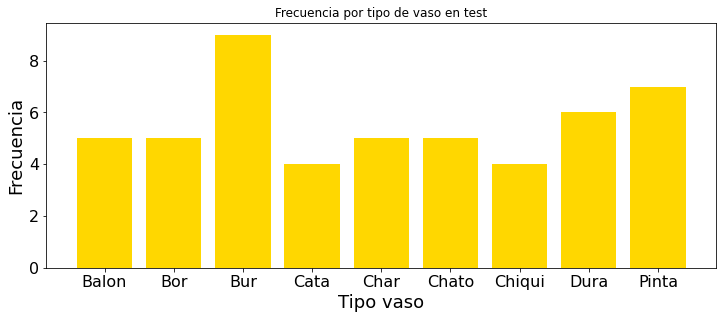

In [16]:
import collections
c = collections.Counter(df_pred.glass)
c = sorted(c.items())
glass = list(set(df_pred.glass))
freq = [i[1] for i in c]
tipo = [i[0] for i in c]
figsize = 1.5
f, ax = plt.subplots(1, 1, figsize=(figsize*8, figsize*3))


plt.bar(tipo, freq, color='gold')
plt.title("Frecuencia por tipo de vaso en "+SPLIT_NAME)
ax.set_xlabel('Tipo vaso', fontsize=18)
ax.set_ylabel('Frecuencia', fontsize=18)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()

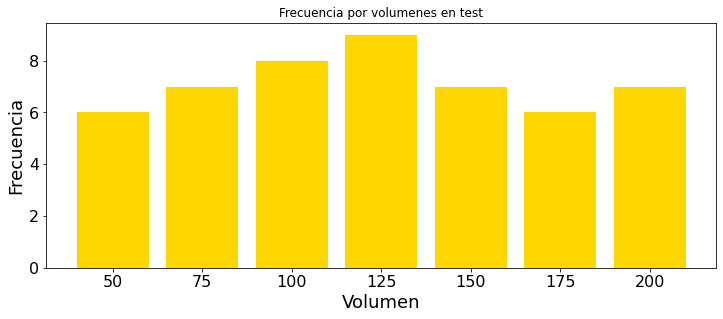

In [17]:
import collections
c = collections.Counter(df_pred.vol)
c = sorted(c.items())
glass = list(set(df_pred.vol))
freq = [i[1] for i in c]
tipo = [i[0] for i in c]
# esto es solo para ordenar los volumenes, para lo cual reordenamos las listas
tipo.insert(0, tipo.pop())
tipo.insert(0, tipo.pop())
freq.insert(0, freq.pop())
freq.insert(0, freq.pop())
###
figsize = 1.5
f, ax = plt.subplots(1, 1, figsize=(figsize*8, figsize*3))


plt.bar(tipo, freq, color='gold')
plt.title("Frecuencia por volumenes en "+SPLIT_NAME)
ax.set_xlabel('Volumen', fontsize=18)
ax.set_ylabel('Frecuencia', fontsize=18)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()

In [18]:
df_pred['vol']=df_pred.vol.astype(int)
df_pred['rel_error']=df_pred.abs_error/df_pred.vol

In [19]:
# groups
df_vols=df_pred.groupby(['vol'], as_index=False)['abs_error'].mean()
# df_backs=df_pred.groupby(['meal'], as_index=False)['abs_error'].mean()
# df_planes=df_pred.groupby(['plane'], as_index=False)['abs_error'].mean()
# df_angles=df_pred.groupby(['angle'], as_index=False)['abs_error'].mean()
df_glasses=df_pred.groupby(['glass'], as_index=False)['abs_error'].mean()
# df_ref=df_pred.groupby(['ref'], as_index=False)['abs_error'].mean()
# df_light=df_pred.groupby(['light'], as_index=False)['abs_error'].mean()

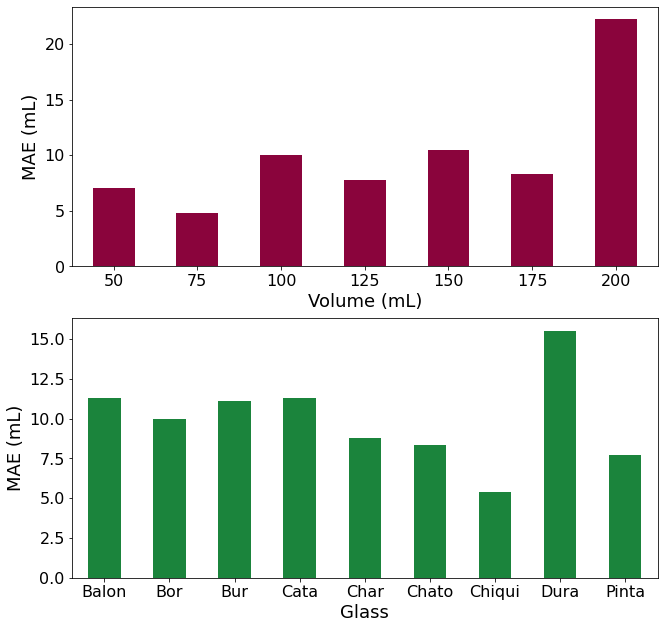

In [21]:
# volumenes en los que se comete un mayor error

figsize = 3.5

fig, axs = plt.subplots(2, 1, figsize=(figsize*3, figsize*3))

df_vols.plot.bar(x='vol', y='abs_error', ax=axs[0], color=['#8a043c'], legend=None) # test '#8a043c'
# train '#5b968a'
axs[0].set_xlabel('Volume (mL)', fontsize=18)
axs[0].set_ylabel('MAE (mL)', fontsize=18)
axs[0].tick_params(axis='x', rotation=0)
axs[0].tick_params(axis='both', which='major', labelsize=16)

df_glasses.plot.bar(x='glass', y='abs_error', ax=axs[1], color=['#1b843c'], legend=None) # test '#1b843c'
# train '#8c713c'
axs[1].set_xlabel('Glass', fontsize=18)
axs[1].set_ylabel('MAE (mL)', fontsize=18)
axs[1].tick_params(axis='x', rotation=0)
axs[1].tick_params(axis='both', which='major', labelsize=16)

In [111]:
custom_dict = {'inf': 0, 'cen': 1, 'sup1': 2, 'sup': 3}
df_angles=df_angles.sort_values(by=['angle'], key=lambda x: x.map(custom_dict))

custom_dict = {'ce': 0, 'me': 1, 'al': 2}
df_planes=df_planes.sort_values(by=['plane'], key=lambda x: x.map(custom_dict))

custom_dict = {'f': 0, 'nf': 1, 'ext': 2, 'nd': 3}
df_light=df_light.sort_values(by=['light'], key=lambda x: x.map(custom_dict))

custom_dict = {'con': 0, 'sin': 1, 'nd': 2}
df_ref=df_ref.sort_values(by=['ref'], key=lambda x: x.map(custom_dict))

NameError: name 'df_angles' is not defined

In [299]:
# rename values 
df_glasses['glass'].loc[(df_glasses['glass'] == 'Chiqu')] = 'Chiqui'

df_backs['back'].loc[(df_backs['back'] == 'nd')] = 'outside'
df_backs['back'].loc[(df_backs['back'] == 'bl')] = 'white'
df_backs['back'].loc[(df_backs['back'] == 'az')] = 'blue'

df_ref['ref'].loc[(df_ref['ref'] == 'nd')] = 'unknown'
df_ref['ref'].loc[(df_ref['ref'] == 'con')] = 'yes'
df_ref['ref'].loc[(df_ref['ref'] == 'sin')] = 'no'

df_planes['plane'].loc[(df_planes['plane'] == 'al')] = '[50, 70]'
df_planes['plane'].loc[(df_planes['plane'] == 'me')] = '[20, 30]'
df_planes['plane'].loc[(df_planes['plane'] == 'ce')] = '[10, 15]'

df_angles['angle'].loc[(df_angles['angle'] == 'sup')] = '(0, 60]'
df_angles['angle'].loc[(df_angles['angle'] == 'sup1')] = '(0, 30]'
df_angles['angle'].loc[(df_angles['angle'] == 'cen')] = '0'
df_angles['angle'].loc[(df_angles['angle'] == 'inf')] = '[-30, 0)'

df_light['light'].loc[(df_light['light'] == 'f')] = 'inside (flash)'
df_light['light'].loc[(df_light['light'] == 'nf')] = 'inside (no flash)'
df_light['light'].loc[(df_light['light'] == 'ext')] = 'outside'
df_light['light'].loc[(df_light['light'] == 'nd')] = 'unknown'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


KeyError: 'back'

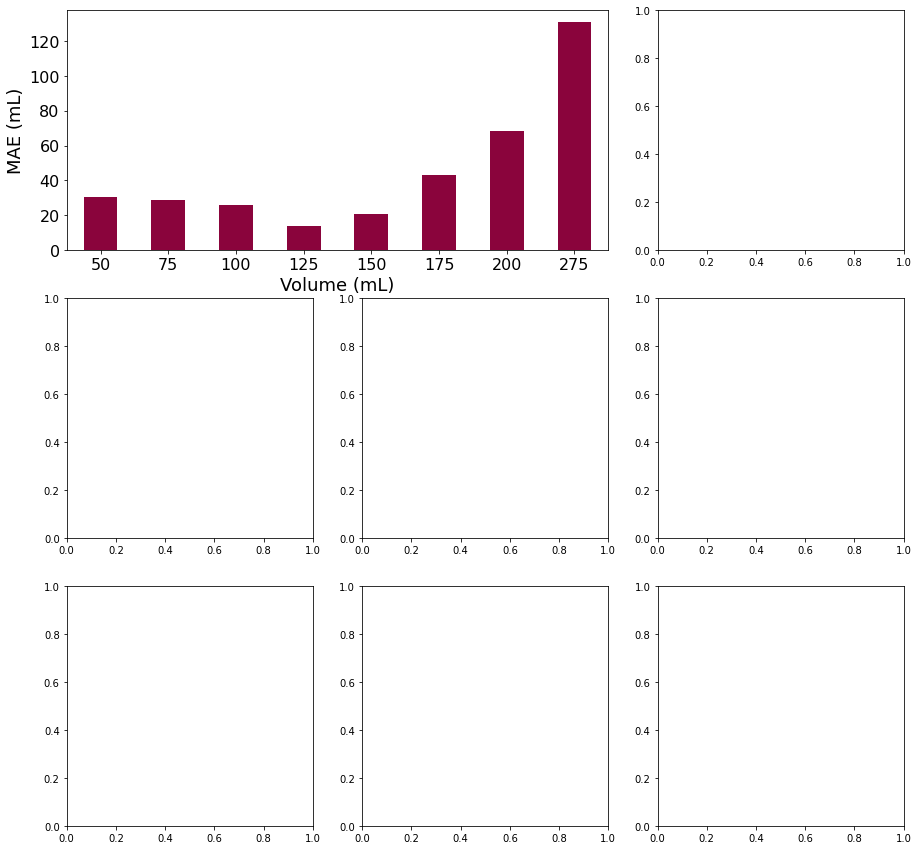

In [12]:
figsize = 5

fig, axs = plt.subplots(3, 3, figsize=(figsize*3, figsize*3))

gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0, 0:-1]:
    ax.remove()
axbig = fig.add_subplot(gs[0, 0:-1])

df_vols.plot.bar(x='vol', y='abs_error', ax=axbig, color=['#8a043c'], legend=None)
axbig.set_xlabel('Volume (mL)', fontsize=18)
axbig.set_ylabel('MAE (mL)', fontsize=18)
axbig.tick_params(axis='x', rotation=0)
axbig.tick_params(axis='both', which='major', labelsize=16)

df_backs.plot.bar(x='back', y='abs_error', ax=axs[0,2], color=['#8a043c'], legend=None)
axs[0,2].set_xlabel('Background', fontsize=18)
axs[0,2].set_ylabel('MAE (mL)', fontsize=18)
axs[0,2].tick_params(axis='x', rotation=0)
axs[0,2].tick_params(axis='both', which='major', labelsize=16)

gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1, 0:-1]:
    ax.remove()
axbig2 = fig.add_subplot(gs[1, 0:-1])

df_glasses.plot.bar(x='glass', y='abs_error', ax=axbig2, color=['#8a043c'], legend=None)
axbig2.set_xlabel('Glass', fontsize=18)
axbig2.set_ylabel('MAE (mL)', fontsize=18)
axbig2.tick_params(axis='x', rotation=0)
axbig2.tick_params(axis='both', which='major', labelsize=16)

df_ref.plot.bar(x='ref', y='abs_error', ax=axs[1,2], color=['#8a043c'], legend=None)
axs[1,2].set_xlabel('Reference', fontsize=18)
axs[1,2].set_ylabel('MAE (mL)', fontsize=18)
axs[1,2].tick_params(axis='x', rotation=0)
axs[1,2].tick_params(axis='both', which='major', labelsize=16)

df_angles.plot.bar(x='angle', y='abs_error', ax=axs[2,0], color=['#8a043c'], legend=None)
axs[2,0].set_xlabel('Angle (deg)', fontsize=18)
axs[2,0].set_ylabel('MAE (mL)', fontsize=18)
axs[2,0].tick_params(axis='x', rotation=0)
axs[2,0].tick_params(axis='both', which='major', labelsize=16)

df_planes.plot.bar(x='plane', y='abs_error', ax=axs[2,1], color=['#8a043c'], legend=None)
axs[2,1].set_xlabel('Object distance (cm)', fontsize=18)
axs[2,1].set_ylabel('MAE (mL)', fontsize=18)
axs[2,1].tick_params(axis='x', rotation=0)
axs[2,1].tick_params(axis='both', which='major', labelsize=16)

df_light.plot.bar(x='light', y='abs_error', ax=axs[2,2], color=['#8a043c'], legend=None)
axs[2,2].set_xlabel('Lighting', fontsize=18)
axs[2,2].set_ylabel('MAE (mL)', fontsize=18)
labels = [item.get_text() for item in axs[2,2].get_xticklabels()]
labels[0] = 'inside\nflash'
labels[1] = 'inside\nno flash'
labels[2] = 'outside'
labels[3] = '\n unknown'
axs[2,2].set_xticklabels(labels)
axs[2,2].tick_params(axis='x', rotation=0)
axs[2,2].tick_params(axis='both', which='major', labelsize=16)

# for ax in axs:
#    ax.tick_params(axis='both', which='major', labelsize=16)
    
fig.tight_layout(pad=3.0)
plt.savefig('/srv/image-results/abs_error.pdf',bbox_inches='tight')

## Ponderar por el número de imágenes de train

Esta parte de momento no la vamos a incluir.

In [221]:
# load training data to weigh number of images of each class
splits_dir = '/srv/images_classes/Regression/copasVasos_Madrid_LaRioja'

# Load the data
data = pd.read_csv(splits_dir+'/train.txt', sep="*", header=None, names=['image', 'clase'])

angles=[]
planes=[]
back=[]
vol=[]
glass=[]
ref=[]
light=[]
for file in data.image:
    l=file.split('_')
    planes.append(l[-2])
    angles.append(l[-1].split('.')[0])
    back.append(l[-4])
    vol.append(int(l[4]))
    glass.append(l[3])
    if l[-1].split('.')[0]=='al':
        print(file)
    ref.append(l[-3])
    light.append(l[-5])

In [222]:
# get counts
from collections import Counter
c_planes=Counter(planes)
c_angles=Counter(angles)
c_back=Counter(back)
c_vol=Counter(vol)
c_glass=Counter(glass)
c_ref=Counter(ref)
c_light=Counter(light)

In [235]:
# relative values
dict_planes=dict()
for i in c_planes:
    dict_planes[i]=c_planes[i]/sum(c_planes.values())

# relative values
dict_angles=dict()
for i in c_angles:
    dict_angles[i]=c_angles[i]/sum(c_angles.values())
    
# relative values
dict_back=dict()
for i in c_back:
    dict_back[i]=c_back[i]/sum(c_back.values())
    
# relative values
dict_vol=dict()
for i in c_vol:
    dict_vol[i]=c_vol[i]/sum(c_vol.values())
    
# relative values
dict_glass=dict()
for i in c_glass:
    dict_glass[i]=c_glass[i]/sum(c_glass.values())
    
# relative values
dict_ref=dict()
for i in c_ref:
    dict_ref[i]=c_ref[i]/sum(c_ref.values())
    
# relative values
dict_light=dict()
for i in c_light:
    dict_light[i]=c_light[i]/sum(c_light.values())

In [249]:
# groups
df_vols=df_pred.groupby(['vol'], as_index=False)['abs_error'].mean()
df_backs=df_pred.groupby(['back'], as_index=False)['abs_error'].mean()
df_planes=df_pred.groupby(['plane'], as_index=False)['abs_error'].mean()
df_angles=df_pred.groupby(['angle'], as_index=False)['abs_error'].mean()
df_glasses=df_pred.groupby(['glass'], as_index=False)['abs_error'].mean()
df_ref=df_pred.groupby(['ref'], as_index=False)['abs_error'].mean()
df_light=df_pred.groupby(['light'], as_index=False)['abs_error'].mean()

In [252]:
for key, value in dict_planes.items():
    df_planes.loc[df_planes['plane']==key, 'train_pond']=value
df_planes['pond_abs_error']=df_planes.abs_error*df_planes.train_pond

for key, value in dict_angles.items():
    df_angles.loc[df_angles['angle']==key, 'train_pond']=value
df_angles['pond_abs_error']=df_angles.abs_error*df_angles.train_pond

for key, value in dict_back.items():
    df_backs.loc[df_backs['back']==key, 'train_pond']=value
df_backs['pond_abs_error']=df_backs.abs_error*df_backs.train_pond
    
for key, value in dict_vol.items():
    df_vols.loc[df_vols['vol']==key, 'train_pond']=value
df_vols['pond_abs_error']=df_vols.abs_error*df_vols.train_pond

for key, value in dict_glass.items():
    df_glasses.loc[df_glasses['glass']==key, 'train_pond']=value
df_glasses['pond_abs_error']=df_glasses.abs_error*df_glasses.train_pond

for key, value in dict_ref.items():
    df_ref.loc[df_ref['ref']==key, 'train_pond']=value
df_ref['pond_abs_error']=df_ref.abs_error*df_ref.train_pond
    
for key, value in dict_light.items():
    df_light.loc[df_light['light']==key, 'train_pond']=value
df_light['pond_abs_error']=df_light.abs_error*df_light.train_pond

In [253]:
custom_dict = {'inf': 0, 'cen': 1, 'sup1': 2, 'sup': 3}
df_angles=df_angles.sort_values(by=['angle'], key=lambda x: x.map(custom_dict))

custom_dict = {'ce': 0, 'me': 1, 'al': 2}
df_planes=df_planes.sort_values(by=['plane'], key=lambda x: x.map(custom_dict))

custom_dict = {'f': 0, 'nf': 1, 'ext': 2, 'nd': 3}
df_light=df_light.sort_values(by=['light'], key=lambda x: x.map(custom_dict))

custom_dict = {'con': 0, 'sin': 1, 'nd': 2}
df_ref=df_ref.sort_values(by=['ref'], key=lambda x: x.map(custom_dict))

In [254]:
# rename values 
df_backs['back'].loc[(df_backs['back'] == 'nd')] = 'outside'
df_backs['back'].loc[(df_backs['back'] == 'bl')] = 'white'
df_backs['back'].loc[(df_backs['back'] == 'az')] = 'blue'

df_ref['ref'].loc[(df_ref['ref'] == 'nd')] = 'unkown'
df_ref['ref'].loc[(df_ref['ref'] == 'con')] = 'yes'
df_ref['ref'].loc[(df_ref['ref'] == 'sin')] = 'no'

df_planes['plane'].loc[(df_planes['plane'] == 'al')] = '[50, 70]'
df_planes['plane'].loc[(df_planes['plane'] == 'me')] = '[20, 30]'
df_planes['plane'].loc[(df_planes['plane'] == 'ce')] = '[10, 15]'

df_angles['angle'].loc[(df_angles['angle'] == 'sup')] = '(0, 60]'
df_angles['angle'].loc[(df_angles['angle'] == 'sup1')] = '(0, 30]'
df_angles['angle'].loc[(df_angles['angle'] == 'cen')] = '0'
df_angles['angle'].loc[(df_angles['angle'] == 'inf')] = '[-30, 0)'

df_light['light'].loc[(df_light['light'] == 'f')] = 'flash inside'
df_light['light'].loc[(df_light['light'] == 'nf')] = 'no flash inside'
df_light['light'].loc[(df_light['light'] == 'ext')] = 'outside'
df_light['light'].loc[(df_light['light'] == 'nd')] = 'unkown'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


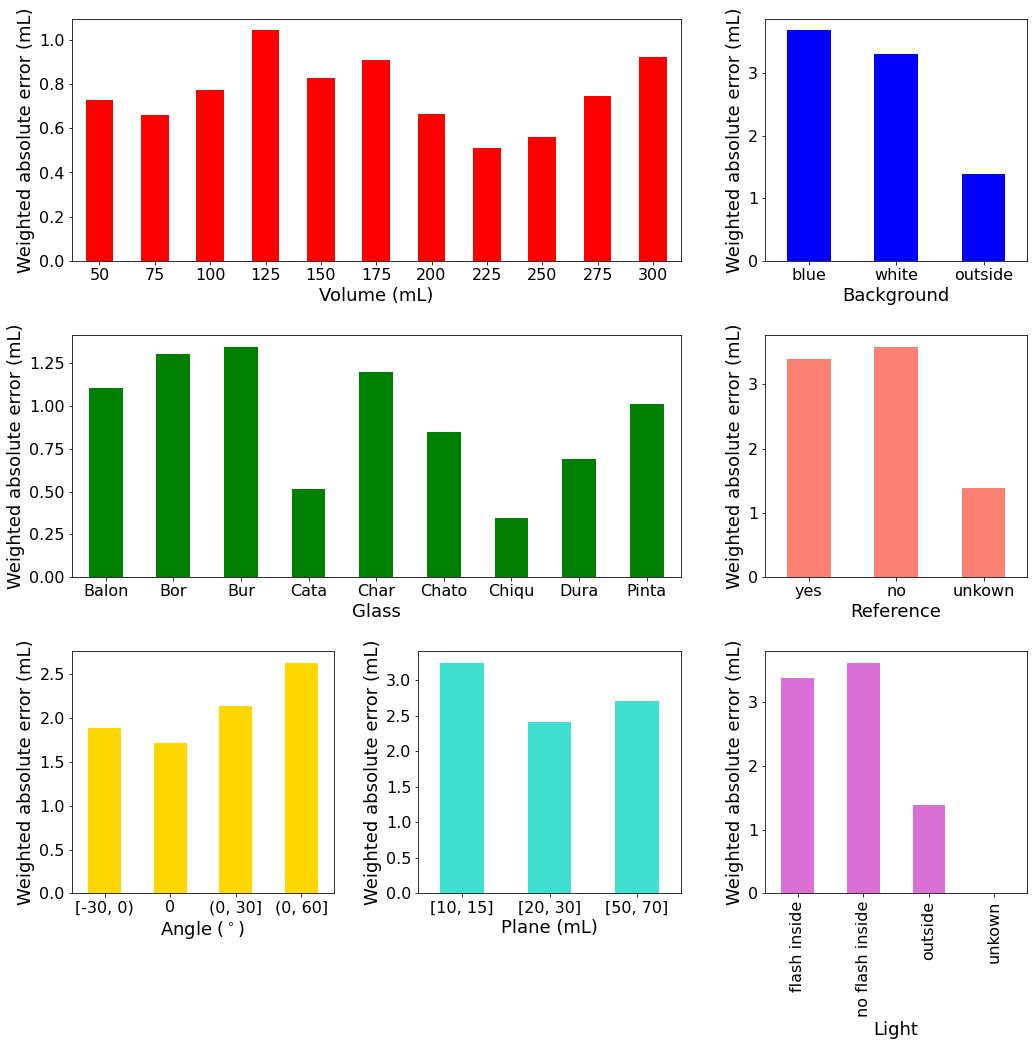

In [258]:
figsize = 5

fig, axs = plt.subplots(3, 3, figsize=(figsize*3, figsize*3))

gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0, 0:-1]:
    ax.remove()
axbig = fig.add_subplot(gs[0, 0:-1])

df_vols.plot.bar(x='vol', y='pond_abs_error', ax=axbig, color=['red'], legend=None)
axbig.set_xlabel('Volume (mL)', fontsize=18)
axbig.set_ylabel('Weighted absolute error (mL)', fontsize=18)
axbig.tick_params(axis='x', rotation=0)
axbig.tick_params(axis='both', which='major', labelsize=16)

df_backs.plot.bar(x='back', y='pond_abs_error', ax=axs[0,2], color=['blue'], legend=None)
axs[0,2].set_xlabel('Background', fontsize=18)
axs[0,2].set_ylabel('Weighted absolute error (mL)', fontsize=18)
axs[0,2].tick_params(axis='x', rotation=0)
axs[0,2].tick_params(axis='both', which='major', labelsize=16)

gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1, 0:-1]:
    ax.remove()
axbig2 = fig.add_subplot(gs[1, 0:-1])

df_glasses.plot.bar(x='glass', y='pond_abs_error', ax=axbig2, color=['green'], legend=None)
axbig2.set_xlabel('Glass', fontsize=18)
axbig2.set_ylabel('Weighted absolute error (mL)', fontsize=18)
axbig2.tick_params(axis='x', rotation=0)
axbig2.tick_params(axis='both', which='major', labelsize=16)

df_ref.plot.bar(x='ref', y='pond_abs_error', ax=axs[1,2], color=['salmon'], legend=None)
axs[1,2].set_xlabel('Reference', fontsize=18)
axs[1,2].set_ylabel('Weighted absolute error (mL)', fontsize=18)
axs[1,2].tick_params(axis='x', rotation=0)
axs[1,2].tick_params(axis='both', which='major', labelsize=16)

df_angles.plot.bar(x='angle', y='pond_abs_error', ax=axs[2,0], color=['gold'], legend=None)
axs[2,0].set_xlabel('Angle ($^\circ$)', fontsize=18)
axs[2,0].set_ylabel('Weighted absolute error (mL)', fontsize=18)
axs[2,0].tick_params(axis='x', rotation=0)
axs[2,0].tick_params(axis='both', which='major', labelsize=16)

df_planes.plot.bar(x='plane', y='pond_abs_error', ax=axs[2,1], color=['turquoise'], legend=None)
axs[2,1].set_xlabel('Plane (mL)', fontsize=18)
axs[2,1].set_ylabel('Weighted absolute error (mL)', fontsize=18)
axs[2,1].tick_params(axis='x', rotation=0)
axs[2,1].tick_params(axis='both', which='major', labelsize=16)

df_light.plot.bar(x='light', y='pond_abs_error', ax=axs[2,2], color=['orchid'], legend=None)
axs[2,2].set_xlabel('Light', fontsize=18)
axs[2,2].set_ylabel('Weighted absolute error (mL)', fontsize=18)
axs[2,2].tick_params(axis='x', rotation=90)
axs[2,2].tick_params(axis='both', which='major', labelsize=16)

# for ax in axs:
#    ax.tick_params(axis='both', which='major', labelsize=16)
    
fig.tight_layout(pad=3.0)
plt.savefig('/srv/image-results/weighted_abs_error.pdf',bbox_inches='tight')